In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorboardX import SummaryWriter
from multiprocessing import Pool

import os
import math
from os import listdir
from os.path import join

import numpy as np
import pickle
from tqdm import tqdm

In [2]:
WORK_DIR = '../Data/bioc-FH-training/'
PROCESSED_TRAIN_DATA_DIR = '../Data/processed/'
PROCESSED_TEST_DATA_DIR = '../Data/processed_test_data/'
LOG_DIR  = '../log/bioc_FH_training/'
OBJECTS_DIR = '../objects/'

lmap = lambda fun, it: list(map(lambda x: fun(x), it))

In [3]:
class Attention(nn.Module):
    
    def __init__(self,d_h):
        super(Attention, self).__init__()
        self.W_q=nn.Linear(in_features=d_h,out_features=d_h,bias=True)
        self.W_k=nn.Linear(in_features=d_h,out_features=d_h,bias=True)
        self.W_v=nn.Linear(in_features=d_h,out_features=d_h,bias=True)
        
    def forward(self,q,k,v,mask):
        Q=self.W_q(q)
        K=self.W_k(k)
        V=self.W_v(v)
        O=torch.matmul(Q,torch.transpose(K,-2,-1))/ math.sqrt(Q.size(-1))
        O=O.masked_fill(mask==0,-1e9)
        E=F.softmax(O,dim=-1)
        R=torch.matmul(E,v)
#        G=F.sigmoid(self.W_g(R))*R
        return R

In [4]:
# -*- coding:utf-8 -*-

class RNN(nn.Module):
    def __init__(self, d_x, d_h, d_ent, d_pos, d_dep, cell=nn.GRU, rnn_layers=3, ffn_layers=5, dp=0.5):
        super(RNN, self).__init__()
        self.dropout = nn.Dropout(p=dp)
        #self.embedding = nn.Embedding(_weight=torch.tensor(emb,dtype=torch.float32),
        #                              num_embeddings=embedding.shape[0],
        #                              embedding_dim=embedding.shape[1])
        self.rnn_layers = rnn_layers
        self.d_h=d_h
        self.rnn = cell(input_size=d_x, hidden_size=d_h, num_layers=rnn_layers, batch_first=True, dropout=dp,bidirectional=True)
        self.ent_attn = Attention(d_h=d_h)
        self.pos_attn = Attention(d_h=d_h)
        self.dep_attn = Attention(d_h=d_h)
        
        self.hidden_ents = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.hidden_poss = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.hidden_deps = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        
        self.lm_ents = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.lm_poss = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.lm_deps = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        
        self.f_ent_out = nn.Linear(in_features=d_h, out_features=d_ent)
        self.f_pos_out = nn.Linear(in_features=d_h, out_features=d_pos)
        self.f_dep_out = nn.Linear(in_features=d_h, out_features=d_dep)
        
        for param in self.parameters(): # initialize parameters
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    
    def forward(self, x, mask, hidden=None):
        rnn_out, _ = self.rnn(x, hidden)
        rnn_out = rnn_out[:, :, :self.d_h] + rnn_out[:, :, self.d_h:]
        
        ent_out_attn = self.ent_attn(q=rnn_out, k=rnn_out, v=rnn_out, mask=mask)
        ent_out = ent_out_attn
        for hl, lm in zip(self.hidden_ents, self.lm_ents):
            ent_out = self.dropout(lm(F.leaky_relu(hl(ent_out))))
        ent_out = self.f_ent_out(ent_out)  # todo for add attention: ent_out_attn
        
        pos_out_attn = self.pos_attn(q=rnn_out,k=rnn_out,v=rnn_out,mask=mask)
        pos_out = pos_out_attn
        for hl, lm in zip(self.hidden_poss, self.lm_poss):
            pos_out = self.dropout(lm(F.leaky_relu(hl(pos_out))))
        pos_out = self.f_pos_out(pos_out_attn + pos_out)
        
        dep_out_attn = self.dep_attn(q=rnn_out,k=rnn_out,v=rnn_out,mask=mask)
        dep_out = dep_out_attn
        for hl, lm in zip(self.hidden_deps, self.lm_deps):
            dep_out = self.dropout(lm(F.leaky_relu(hl(dep_out))))
        dep_out = self.f_dep_out(dep_out_attn + dep_out)
        
        return ent_out, pos_out, dep_out

In [5]:
class Classifier(object):
    def __init__(self, model, dp=0.5,lr=1e-3):
        super(Classifier, self).__init__()
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
    def train(self, X, mask, y_ent, y_pos, y_dep):
        x = torch.tensor(X, dtype=torch.float)
        attn_mask = (mask > 0).unsqueeze(1).repeat(1, mask.size(1), 1)
        loss_mask = mask
        y_true_ent = torch.tensor(y_ent, dtype=torch.long)
        y_true_pos = torch.tensor(y_pos, dtype=torch.long)
        y_true_dep = torch.tensor(y_dep, dtype=torch.long)
        self.model.train(True)
        self.optimizer.zero_grad()
        y_hat_ent,y_hat_pos,y_hat_dep = self.model(x,attn_mask)
        
        loss_ent = self.maskNLLLoss(y_hat_ent, y_true_ent, loss_mask)
        loss_pos = self.maskNLLLoss(y_hat_pos, y_true_pos, loss_mask)
        loss_dep = self.maskNLLLoss(y_hat_dep, y_true_dep, loss_mask)
        reg_lambda=1e-4
        l2_reg = 0
        
        for W in self.model.named_parameters(): # regularizer
            if "weight" in W[0]:
                l2_reg = l2_reg + W[1].norm(2)
        loss=loss_ent+loss_pos+loss_dep+l2_reg * reg_lambda
        loss.backward()
        clip_grad_norm_(self.model.parameters(), 1) # gradient clip -> avoid gradient explosion
        self.optimizer.step()
        y_hat_ent = y_hat_ent.topk(1)[1].squeeze(-1).detach().cpu()
        y_hat_pos = y_hat_pos.topk(1)[1].squeeze(-1).detach().cpu()
        y_hat_dep = y_hat_dep.topk(1)[1].squeeze(-1).detach().cpu()
        return loss_ent.item(), loss_pos.item(), loss_dep.item(), y_hat_ent.numpy(), y_hat_pos.numpy(), y_hat_dep.numpy()
    
    def test(self, X, mask, y_ent, y_pos, y_dep):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X, dtype=torch.float)
            attn_mask = (mask > 0).unsqueeze(1).repeat(1, mask.size(1), 1)
            loss_mask = mask
            y_true_ent = torch.tensor(y_ent, dtype=torch.long)
            y_true_pos = torch.tensor(y_pos, dtype=torch.long)
            y_true_dep = torch.tensor(y_dep, dtype=torch.long)
            y_hat_ent,y_hat_pos,y_hat_dep = self.model(x,attn_mask)
            
            loss_ent = self.maskNLLLoss(y_hat_ent, y_true_ent, loss_mask)
            loss_pos = self.maskNLLLoss(y_hat_pos, y_true_pos, loss_mask)
            loss_dep = self.maskNLLLoss(y_hat_dep, y_true_dep, loss_mask)
            
            y_hat_ent = y_hat_ent.topk(1)[1].squeeze(-1).detach().cpu()
            y_hat_pos = y_hat_pos.topk(1)[1].squeeze(-1).detach().cpu()
            y_hat_dep = y_hat_dep.topk(1)[1].squeeze(-1).detach().cpu()
            
            return loss_ent.cpu().item(), loss_pos.cpu().item(), loss_dep.cpu().item(), y_hat_ent.numpy(), y_hat_pos.numpy(), y_hat_dep.numpy()
    
    def inference(self, X, mask):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X, dtype=torch.float)
            attn_mask = (mask > 0).unsqueeze(1).repeat(1, mask.size(1), 1)
            y_hat_ent,y_hat_pos,y_hat_dep = self.model(x,attn_mask)
            y_hat_ent = y_hat_ent.topk(1)[1].squeeze(-1).detach().cpu()
            y_hat_pos = y_hat_pos.topk(1)[1].squeeze(-1).detach().cpu()
            y_hat_dep = y_hat_dep.topk(1)[1].squeeze(-1).detach().cpu()
            return y_hat_ent.numpy().flatten(), y_hat_pos.numpy(), y_hat_dep.numpy()
    
    def maskNLLLoss(self, logits, target, mask):
        logits=F.softmax(logits,dim=-1)
        crossEntropy = -torch.log(logits.gather(-1,target[:,:,None])).squeeze(-1)
        loss = crossEntropy.masked_select(mask).mean()
        return loss
    
    def load_model(self, model_path='./Model'):
        self.model = torch.load(model_path + '/model.pkl')
    
    def save_model(self, model_path='./Model'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.model, model_path + '/model.pkl')

def build_conv(n_gram=[1,3,5],in_channels=[300,300,300], out_channels=[50,50,50]):
    convs=nn.ModuleList([nn.Conv1d(in_channels=d_in,out_channels=d_out,kernel_size=n,padding=p,stride=1) for p,(d_in, d_out, n) in enumerate(zip(in_channels,out_channels,n_gram))])
    return convs
        
def pad(sents,dim=5):
    padded=[]
    max_leng=max(lmap(lambda x:x.shape[0],sents))
    for s in sents:
        if s.shape[0]<=max_leng:
            padded.append(np.concatenate((s,np.zeros((max_leng-s.shape[0],dim),dtype=np.int32))))
    return np.array(padded)

def unpad(y_true, y_hat):
    y_true = np.concatenate(y_true)
    y_hat = np.concatenate(y_hat)
    idx = (y_true != 0)
    y_true = y_true[idx]
    y_hat = y_hat[idx]
    return y_true, y_hat

def mask_unpad(mask, y_hat):
    y_hat = np.concatenate(y_hat)
    idx = (mask != 0)
    mask = mask[idx]
    y_hat = y_hat[idx]
    return y_hat

# Training

In [6]:
with open(OBJECTS_DIR + 'label_dict.pkl','rb') as f:
    ent, pos, dep = pickle.load(f)

d_ent=len(ent)
d_pos=len(pos)
d_dep=len(dep)

print(ent)

{'<PAD>': 0, 'FM': 1, 'O': 2, 'LS-2': 3, 'OBS': 4, 'LS-0': 5, 'Maternal': 6, 'Paternal': 7, 'LS-4': 8}


In [7]:
model=RNN(d_x=1024,d_h=100,d_ent=d_ent,d_pos=d_pos,d_dep=d_dep,rnn_layers=1,ffn_layers=2)

/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
clf = Classifier(model=model,lr=1e-3)

In [9]:
with open(join(OBJECTS_DIR, 'train_corpus.pkl'), 'rb') as pkl_f:
    corpus = pickle.load(pkl_f)
    
with open(OBJECTS_DIR + 'train_corpus_labels.pkl','rb') as f:
    labels = pickle.load(f)

In [10]:
writer = SummaryWriter(log_dir=LOG_DIR)
train_size = 72

text_files = list(corpus.keys())

def read_emb_f(path2file):
    with open(path2file + '.emb.pkl', 'rb') as emb_f:
        embedding = pickle.load(emb_f)
    return embedding

pool = Pool(processes=24) 
emb_files = pool.map(read_emb_f, [PROCESSED_TRAIN_DATA_DIR + text_file for text_file in text_files])

train_data = []
for idx, title in enumerate(text_files[:train_size]):
    train_data.append((emb_files[idx], labels[title]))

valid_data = []
for idx, title in enumerate(text_files[train_size:]):
    valid_data.append((emb_files[idx+train_size], labels[title]))

In [11]:
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
batch_size=32  # 64 got great performance

for e in tqdm(range(20)):
    np.random.shuffle(train_data)
    for fi, f in enumerate(train_data):
        
        emb_corpus = f[0]
        label = lmap(lambda x: np.array(x), f[1])
        label = pad(label, dim=3)
        dl = []
        i = 0

        while i < label.shape[0]:
            if label.shape[0] == 0: break
            x = emb_corpus['elmo_representations'][0][i:i + batch_size]
            mask =  emb_corpus['mask'].type(torch.uint8)[i:i + batch_size]
            y = label[i:i + batch_size]
            l1,l2,l3,y1,y2,y3=clf.train(x,mask,y_ent=y[:,:,0],y_pos=y[:,:,1],y_dep=y[:,:,2])
            i += batch_size
            dl.append(l1+l2+l3)
        writer.add_scalar('train loss',np.mean(dl),e*len(train_data)+fi)
        #print(f'train epoch: {e}, doc: {fi}, loss: {np.mean(dl):.2f}')
    # print('-'*18)

    tall, pall = [], []
    valid_labels = []
    valid_result = []
    for fi, f in enumerate(valid_data):
        emb_corpus = f[0]
        
        label = lmap(lambda x: np.array(x), f[1])
        valid_labels.append(label)
        label = pad(label,dim=3)
        
        pent, ppos, pdep = [], [], []
        tent, tpos, tdep = [], [], []
        
        dl = []
        i=0
        while i<label.shape[0]:
            if label.shape[0]==0:break
            x = emb_corpus['elmo_representations'][0][i:i+batch_size]
            mask =  emb_corpus['mask'].type(torch.uint8)[i:i+batch_size]
            y = label[i:i+batch_size]
            l1,l2,l3,y1,y2,y3=clf.test(x,mask,y_ent=y[:,:,0],y_pos=y[:,:,1],y_dep=y[:,:,2])
            i += batch_size
            dl.append(l1+l2+l3)
            pent.append(y1.flatten())
            ppos.append(y2.flatten())
            pdep.append(y3.flatten())
            tent.append(y[:,:,0].flatten())
            tpos.append(y[:,:,1].flatten())
            tdep.append(y[:,:,2].flatten())
        tent, pent = unpad(tent,pent)
        tpos, ppos = unpad(tpos,ppos)
        tdep, pdep = unpad(tdep,pdep)
        
        acc = accuracy_score(y_true=tent,y_pred=pent) + \
              accuracy_score(y_true=tpos,y_pred=ppos) + \
              accuracy_score(y_true=tdep,y_pred=pdep)
        
        # tent = (tent==ent['OBS']) * tent / ent['OBS']
        # pent = (pent==ent['OBS']) * pent / ent['OBS']
        
        tall.extend(tent)
        pall.extend(pent)
        valid_result += list(pent)
        lp = precision_score(y_true=tent, y_pred=pent, average=None)
        lr = recall_score(y_true=tent, y_pred=pent, average=None)
        lf1 = f1_score(y_true=tent, y_pred=pent, average=None)
        
        writer.add_scalar('test loss', np.mean(dl),e*len(valid_data)+fi)
        writer.add_scalar('test acc', acc,e*len(valid_data)+fi)
        writer.add_scalar('loc precision', np.mean(lp), e*len(valid_data)+fi)
        writer.add_scalar('loc recall',np.mean(lr),e*len(valid_data)+fi)
        writer.add_scalar('loc f1-score',np.mean(lf1),e*len(valid_data)+fi)
        
    print(f'test epoch: {e}, doc: {fi}, loss: {np.mean(dl)}, acc: {acc}')
    print("precision:", lp)
    print("recall:", lr)
    print("f1-score:", lf1)
    print('-'*18)
    
np.save(OBJECTS_DIR+'ner_elmo_valid_result', valid_result)

In [13]:
classes = list(ent)

In [14]:
true_valid_labels = []
for doc_labels in valid_labels:
    for sent_labels in doc_labels:
        for word_label in sent_labels:
            true_valid_labels.append(word_label[0])

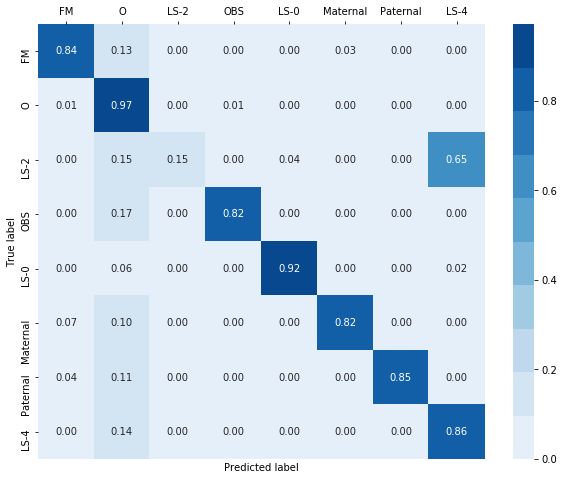

In [15]:
cm = confusion_matrix(y_true=true_valid_labels, y_pred=valid_result)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=classes[1:], columns=classes[1:])
plt.figure(figsize=(10,8))
ax = sn.heatmap(df_cm, annot=True, fmt='.2f',cmap=sn.color_palette("Blues", n_colors=10))
ax.set(ylabel='True label', xlabel='Predicted label')
ax.xaxis.tick_top()

In [16]:
p = precision_score(y_true=true_valid_labels, y_pred=valid_result, average=None)
r = recall_score(y_true=true_valid_labels, y_pred=valid_result, average=None)
f1 = f1_score(y_true=true_valid_labels, y_pred=valid_result, average=None)
print(p)
print(r)
print(f1)
# print(f'precision: {p:.2f}, recall: {r:.2f}, f1-score: {f1:.2f}')

[0.67058824 0.98040089 1.         0.83555556 0.78947368 0.67226891
 0.88607595 0.64556962]
[0.84444444 0.9724595  0.15384615 0.8209607  0.92307692 0.82474227
 0.85365854 0.86440678]
[0.74754098 0.97641405 0.26666667 0.82819383 0.85106383 0.74074074
 0.86956522 0.73913043]


In [17]:
from collections import Counter
Counter(tall)

Counter({2: 6790, 6: 97, 4: 458, 5: 65, 1: 135, 7: 82, 3: 26, 8: 59})

In [18]:
Counter(pall)

Counter({2: 6735, 6: 119, 4: 450, 5: 76, 1: 170, 7: 79, 8: 79, 3: 4})

# Testing

In [19]:
with open(join(OBJECTS_DIR, 'test_corpus.pkl'), 'rb') as pkl_f:
    test_corpus = pickle.load(pkl_f)

with open(OBJECTS_DIR + 'test_corpus_labels.pkl','rb') as f:
    labels = pickle.load(f)

test_text_files = list(test_corpus.keys())

test_emb_files = pool.map(read_emb_f, [PROCESSED_TEST_DATA_DIR + text_file for text_file in test_text_files])

test_data = []
for idx, title in enumerate(test_text_files):
    test_data.append((test_emb_files[idx], labels[title]))
    

In [ ]:
test_result = []
print("Number of test files:", len(test_data))

for fi, f in enumerate(test_data):
    emb_corpus = f[0]
    label = lmap(lambda x: np.array(x), f[1])
    pad_label = pad(label, dim=3)
    
    pent = []
    ppos = []
    pdep = []
    
    i=0
    while i<pad_label.shape[0]:
        if pad_label.shape[0]==0: break
        x = emb_corpus['elmo_representations'][0][i:i+batch_size]
        mask =  emb_corpus['mask'].type(torch.uint8)[i:i+batch_size]

        y1,y2,y3=clf.inference(x,mask)
        i+=batch_size
        pent.append(y1.flatten())
        ppos.append(y2.flatten())
        pdep.append(y3.flatten())
        
    mask = emb_corpus['mask'].numpy().flatten()
    pent = mask_unpad(mask,pent)
    ppos = mask_unpad(mask,ppos)
    pdep = mask_unpad(mask,pdep)
    # pent = (pent==ent['OBS'])*pent/ent['OBS']
    test_result += list(pent)
    
np.save(OBJECTS_DIR+'ner_elmo_test_result', test_result)

In [ ]:
def collect_ner_result(text_files, corpus, stage="valid"):
    i = 0
    ner_result = {}
    ner4subtask2 = {}

    docs_pred_labels = np.load(OBJECTS_DIR + f'ner_elmo_{stage}_result.npy', allow_pickle=True)
    for index, txt_file in enumerate(text_files):
        fms, obs = set(), set() # a set for each txt_file
        doc_ner = []
        for sent in corpus[txt_file]:
    #         sent_fms, sent_obs = [], [] # TODO 
            last_class, last_content = "", []
            sent_ner = []

            for tid, token in enumerate(sent):
                if stage == "valid" and classes[docs_pred_labels[i]] != classes[true_valid_labels[i]]:
                    print('\t\t'.join([token,
                                       classes[docs_pred_labels[i]],
                                       classes[true_valid_labels[i]]]))
                pred_class = classes[docs_pred_labels[i]]
                i += 1
                if pred_class in ["FM", "Paternal", "Maternal"]:
                    sent_ner.append(pred_class)
                    if token.capitalize().rstrip('s') in ["Father", "Mother", "Parent",
                        "Sister", "Brother", "Daughter", "Son", "Child", "Grandmother", \
                        "Grandfather", "Grandparent", "Cousin", "Sibling", \
                        "Aunt", "Uncle"]:

                        if pred_class == 'FM':
                            fms.add(("FamilyMember", token.capitalize().rstrip('s'), "NA"))
                        else:
                            fms.add(("FamilyMember", token.capitalize().rstrip('s'),
                                     pred_class))
                    elif token.lower() == 'dad':
                        fms.add(("FamilyMember", "Father", "NA"))
                    elif token.lower() == 'mom':
                        fms.add(("FamilyMember", "Mother", "NA"))
                    else:
                        # print("ignore:", token, pred_class)
                        sent_ner[-1] = "O"
                elif pred_class == last_class and pred_class == "OBS":
                    last_content += [token]
                    sent_ner.append("OBS")
                elif pred_class.startswith("LS"):
                    sent_ner.append(pred_class)
                else:
                    if last_class == 'OBS' and last_content:
                        obs.add(("Observation", " ".join(last_content)))

                    if pred_class == "OBS":
                        last_class, last_content = pred_class, [token]
                        sent_ner.append("OBS")
                    else:
                        last_class, last_content = "", []
                        sent_ner.append("O")
            doc_ner.append(sent_ner)
        ner4subtask2[txt_file] = doc_ner
        ner_result[txt_file] = list(fms) + list(obs)
    #     print(ner_result)
    
    with open(join(OBJECTS_DIR, f'subtask1_result_{stage}.tsv'), 'w') as f:
        for txt_file, content in ner_result.items():
            for items in content:
                f.write("\t".join([txt_file] + list(items)))
                f.write("\n")

    return ner4subtask2

test_ner4subtask2 = collect_ner_result(test_text_files, test_corpus, "test")
valid_ner4subtask2 = collect_ner_result(text_files[train_size:], corpus,"valid")

# Generating training data for subtask2

In [22]:
def get_entity_content(sent, tagged_sents, tag):
    """ return a list of named entities from continues words in sent with tag `tag`
    """
    named_entity, last_tag = [], ""
    ret = []
    for word, cur_tag in zip(sent, tagged_sents):
        if cur_tag == last_tag and cur_tag == tag:
            named_entity.append(word)
        elif cur_tag != last_tag:
            if named_entity:
                ret.append(" ".join(named_entity))

            if cur_tag == tag:
                last_tag, named_entity = tag, [word]
            else:
                last_tag, named_entity = "", []
            
    return ret

In [23]:
def replace_named_entity(sent, sent_id, tagged_sent, tag, replacement):
    replaced_sents = []
    
    if tag in tagged_sent:
        entities = get_entity_content(sent, tagged_sent, tag)
        
        for entity in entities:
            replaced_sent = " ".join(sent).replace(entity, '@'+replacement+'$')
            if tag.startswith("LS-"):
                info4subtask2 = tag
            else:
                info4subtask2 = entity
            replaced_sents.append((sent_id, replaced_sent, info4subtask2, replacement))

    return replaced_sents

In [24]:
def combine_training_instance(doc, fms_sents, obs_sents, ls_sents, sents):
    instances = []
    for fm_sent_id, fm_sent, fm, fm_replacement in fms_sents:
        
        # Generate instances for relation prediction, each instances has two masked entities
        # one familymember and one observation or livingstatus
        for snd_sents in [obs_sents, ls_sents]:
            for ent_sent_id, ent_sent, ent, ent_replacement in snd_sents:
                to_predict = False
                if fm_sent_id == ent_sent_id:
                    to_predict = True
                    instance_id = "_".join([doc, str(fm_sent_id)])
                    instance_sent = fm_sent.replace(ent, "@"+ent_replacement+"$")
                elif 0 < ent_sent_id - fm_sent_id < 3:
                    to_predict = True
                    middle_sents = []
                    for sent in sents[fm_sent_id+1:ent_sent_id]:
                        middle_sents.append(" ".join(sent))

                    instance_sent = " ".join([fm_sent] + middle_sents + [ent_sent])
                    instance_id = "_".join([doc, str(fm_sent_id), str(ent_sent_id)])
                    
                if to_predict:
                    instance = (instance_id, instance_sent, "OTHERS", fm, ent)
                    instances.append(instance)

    return instances

In [ ]:
tag_replacement_map = {
    'FM': 'Relative', 'Paternal': 'PaternalRelative', 'Maternal': 'MaternalRelative',
    'LS-0': 'Status', 'LS-2': 'Status', 'LS-4': 'Status',
    'OBS': 'Disease',
}

def generate_subtask2_data(ner4subtask2, corpus):
    sub2_training_data = [] # store final training instances

    for txt_file, tagged_sents in ner4subtask2.items():
        # sents with fms and obs, with format (sent_id, sent_content)
        fms_sents, obs_sents, ls_sents = [], [], []

        for i, sent in enumerate(corpus[txt_file]):
            assert(len(sent) == len(tagged_sents[i]))
            print(tagged_sents[i])

            for tag, replacement in tag_replacement_map.items():
                replaced_sents = replace_named_entity(sent, i, tagged_sents[i],
                                                      tag, replacement)
                if tag in ['FM', 'Paternal', 'Maternal']:
                    fms_sents += replaced_sents
                elif tag == 'OBS':
                    obs_sents += replaced_sents
                elif tag.startswith('LS'):
                    ls_sents += replaced_sents
            # print(fms_sents)
            # print(obs_sents)
            # print(ls_sents)

        sub2_training_data += combine_training_instance(txt_file, fms_sents, obs_sents,
                                                        ls_sents, corpus[txt_file])
    return sub2_training_data

sub2_training_data_from_valid = generate_subtask2_data(valid_ner4subtask2, corpus)

In [ ]:
sub2_training_data_from_test = generate_subtask2_data(test_ner4subtask2, test_corpus)

In [ ]:
sub2_training_data_from_valid

In [ ]:
sub2_training_data_from_test

In [29]:
def write_instances(path, file_name, sub2_training_data):
    with open(join("../Data/", file_name), 'w') as s2test:
        for instance in sub2_training_data:
            s2test.write("\t".join(list(instance)))
            s2test.write("\n")
write_instances("../Data/", "subtask2_data_from_valid.txt", sub2_training_data_from_valid)
write_instances("../Data/", "subtask2_data_from_test.txt", sub2_training_data_from_test)